In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/taxi_data/preprocessed_data_2020.csv')
df.head()

,time_category_encoded,month,day,PULocationID,DOLocationID,trip_distance,total_amount
0,1,1,1,74,74,0.46,4.8
1,1,1,1,74,69,1.88,9.8
2,1,1,1,41,41,0.76,7.8
3,1,1,1,49,181,2.24,11.8
4,1,1,1,244,244,0.60,6.3


# Training

In [ ]:
# Now filter the DataFrame to include only data from months 2,3.
df = df[df['month'].isin([2,3])]
df.shape

(595715, 7)

In [ ]:
y=df['total_amount']
x=df.drop(columns=['total_amount'])
x.shape,y.shape

((595715, 6), (595715,))

In [ ]:
from sklearn.model_selection import  train_test_split
x_train, x_test, y_train , y_test = train_test_split(x,y, test_size= 0.3, random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(417000, 6)
(417000,)
(178715, 6)
(178715,)


# xgboost

In [ ]:
pip install xgboost

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found for xgboost:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}

Evaluation of the best XGBoost model after Grid Search tuning:
MAE:  2.7727
MSE:  24.5680
RMSE: 4.9566
R²:   0.8614


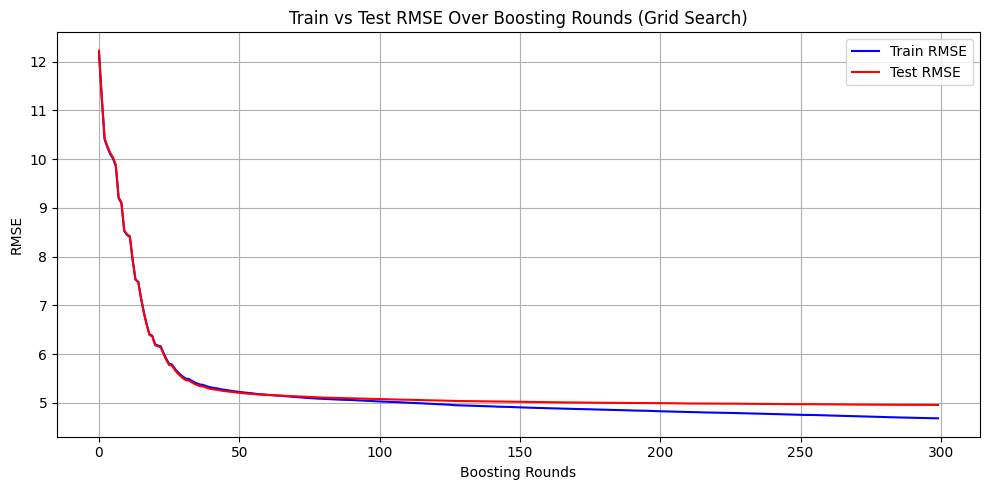

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define parameter grid (smaller set for practicality)
param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Base model
xgb_model = xgb.XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    verbosity=0,
    eval_metric='rmse'
)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search model
grid_search.fit(x_train, y_train)

# Best estimator
best_xgb_model_tuned_grid = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found for xgboost: ", grid_search.best_params_)

# Refit best model with eval_set to collect learning curves
best_xgb_model_tuned_grid.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=False
)

# Predictions
y_pred_xgb_tuned_grid = best_xgb_model_tuned_grid.predict(x_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_xgb_tuned_grid)
mse = mean_squared_error(y_test, y_pred_xgb_tuned_grid)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb_tuned_grid)

print("\nEvaluation of the best XGBoost model after Grid Search tuning:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Plot Learning Curves (Train vs Test RMSE)
results = best_xgb_model_tuned_grid.evals_result()

train_rmse = results['validation_0']['rmse']
test_rmse = results['validation_1']['rmse']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE', color='blue')
plt.plot(test_rmse, label='Test RMSE', color='red')
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE Over Boosting Rounds (Grid Search)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Base model
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    random_state=42,
)

#Training the model
xgb_model.fit(x_train, y_train)

# Prediction
y_pred = xgb_model.predict(x_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.7727
MSE:  24.5680
RMSE: 4.9566
R²:   0.8614
